In [1]:
from utils.data.dataset_ingredient import *
from sklearn.model_selection import train_test_split
from collections import Counter
from tqdm import tqdm
from utils.training import *
from utils.training import evaluate, _Metrics
from models.ingredient import model_ingredient, get_model
from utils.metrics import recall_at_ks_full, fp_fn_eval
import torch
from torch import nn
from scipy.spatial.distance import mahalanobis
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

## Re-split dataset into train/pool/test

In [ ]:
# train_data = open('data/InShop/train.txt').readlines()
# # test_data = open('data/Stanford_Online_Products/test.txt').readlines()
# test_data = open('data/InShop/test_gallery.txt').readlines() + open('data/InShop/test_query.txt').readlines()

In [ ]:
# # split some training into query+testing 
# train_imgs = [x.strip().split(',')[0] for x in train_data]
# train_labels = [x.strip().split(',')[1] for x in train_data]

# # split into testing and query 
# test_imgs = [x.strip().split(',')[0] for x in test_data]
# test_labels = [x.strip().split(',')[1] for x in test_data]

In [2]:
# train_keep_imgs, train_left_imgs, train_keep_labels, train_left_labels = train_test_split(train_imgs, train_labels, 
#                                                                                         test_size=0.33, 
#                                                                                         random_state=42, 
# #                                                                                         stratify=train_labels  
#                                                                                          )


In [3]:
# for j in range(len(train_keep_imgs)):
#     with open('data/InShop/train_small.txt', 'a+') as f:
#         f.write(train_keep_imgs[j] + ',' + train_keep_labels[j] + '\n')

In [4]:
# # split into testing and query 
# test_imgs += train_left_imgs
# test_labels += train_left_labels

In [5]:
# query_imgs, test_keep_imgs, query_labels, test_keep_labels = train_test_split(test_imgs, test_labels, 
#                                                                               test_size=0.33, 
# #                                                                               test_size=0.5, 
#                                                                               random_state=42, 
# #                                                                               stratify=test_labels,
#                                                                              )


In [6]:
# for j in range(len(query_imgs)):
#     with open('data/InShop/pool.txt', 'a+') as f:
#         f.write(query_imgs[j] + ',' + query_labels[j] + '\n')

In [7]:
# for j in range(len(test_keep_imgs)):
#     with open('data/InShop/test_new.txt', 'a+') as f:
#         f.write(test_keep_imgs[j] + ',' + test_keep_labels[j] + '\n')

In [47]:
# print('Num training: {}'.format(len(open('data/CUB_200_2011//train_small.txt').readlines())))
# print('Num query: {}'.format(len(open('data/CUB_200_2011//pool.txt').readlines())))
# print('Num test: {}'.format(len(open('data/CUB_200_2011//test_new.txt').readlines())))

Num training: 3928
Num query: 5266
Num test: 2594


## Load configurations

In [2]:
general_config = data_ingredient.configurations[0]()
# data_config = data_ingredient.named_configs['sop']() # experiment's config
data_config = data_ingredient.named_configs['inshop_vae']() # experiment's config


train_file = data_config['train_file'] if 'train_file' in data_config.keys() else general_config['train_file']
test_file = data_config['test_file'] if 'test_file' in data_config.keys() else general_config['test_file']
pool_file = data_config['pool_file'] if 'pool_file' in data_config.keys() else general_config['pool_file']
sampler = general_config['sampler']
batch_size = general_config['batch_size']
test_batch_size = general_config['test_batch_size']
preload = general_config['preload']
num_workers = general_config['num_workers']
pin_memory = general_config['pin_memory']
scale = general_config['scale']
ratio = general_config['ratio']
recalls = general_config['recalls']

name = data_config['name']
data_path = data_config['data_path']
resize = data_config['resize'] if 'resize' in data_config.keys() else None
rotate = data_config['rotate'] if 'rotate' in data_config.keys() else None
color_jitter = data_config['color_jitter'] if 'color_jitter' in data_config.keys() else None
crop_size = data_config['crop_size'] if 'crop_size' in data_config.keys() else general_config['crop_size']


scale = data_config['scale'] if 'scale' in data_config.keys() else scale
ratio = data_config['ratio'] if 'ratio' in data_config.keys() else ratio
recalls = data_config['recalls'] if 'recalls' in data_config.keys() else recalls


In [3]:
def get_sets(name, data_path, train_file, test_file, pool_file, preload, num_workers):
    train_transform, test_transform = get_transforms(crop_size, 
                                                     scale, ratio, 
                                                     resize, rotate, 
                                                     color_jitter)

    train_lines = read_file(os.path.join(data_path, train_file))
    train_samples = [(os.path.join(data_path, line.split(',')[0]), int(line.split(',')[1])) for line in train_lines]
    train_set = ImageDataset(train_samples, transform=train_transform, 
                             preload=preload, num_workers=num_workers)

    query_lines = read_file(os.path.join(data_path, test_file))
    query_samples = [(os.path.join(data_path, line.split(',')[0]), int(line.split(',')[1])) for line in query_lines]
    query_set = ImageDataset(query_samples, transform=test_transform, preload=preload, num_workers=num_workers)
    gallery_set = None
        
    # pool set
    pool_lines = read_file(os.path.join(data_path, pool_file))
    pool_samples = [(os.path.join(data_path, line.split(',')[0]), int(line.split(',')[1])) for line in pool_lines]
    pool_set = ImageDataset(pool_samples, transform=test_transform, preload=preload, num_workers=num_workers)

    return train_set, (query_set, gallery_set, pool_set)


In [4]:
def get_loaders(batch_size, test_batch_size, num_workers, pin_memory, sampler, recalls,
                num_iterations=None, num_identities=None):
    
    train_set, (query_set, gallery_set, pool_set) = get_sets(name, data_path, 
                                                             train_file, test_file, pool_file,
                                                             preload, num_workers)

    if sampler == 'random':
        train_sampler = BatchSampler(RandomSampler(train_set), batch_size=batch_size, drop_last=True)
    elif sampler == 'random_id':
        train_sampler = RandomReplacedIdentitySampler(train_set.targets, batch_size, num_identities, num_iterations)
    else:
        raise ValueError('Invalid choice of sampler ({}).'.format(sampler))
    train_loader = DataLoader(train_set, batch_sampler=train_sampler, num_workers=num_workers, pin_memory=pin_memory)
    train_noshuffle = DataLoader(train_set, batch_size=test_batch_size,num_workers=num_workers, pin_memory=pin_memory)
    query_loader = DataLoader(query_set, batch_size=test_batch_size, num_workers=num_workers, pin_memory=pin_memory)
    gallery_loader = None
    if gallery_set is not None:
        gallery_loader = DataLoader(gallery_set, batch_size=test_batch_size, num_workers=num_workers,
                                    pin_memory=pin_memory)

    pool_loader = DataLoader(pool_set, batch_size=test_batch_size, num_workers=num_workers, pin_memory=pin_memory)
    
    return MetricLoaders(train=train_loader, query=query_loader, pool=pool_loader, gallery=gallery_loader, 
                         train_noshuffle = train_noshuffle,
                         num_classes=len(set(train_set.targets))), recalls

In [5]:
loaders, recall_ks = get_loaders(batch_size, test_batch_size, num_workers, pin_memory, sampler, recalls)

In [28]:
len(loaders.train.dataset)

39899

In [29]:
len(loaders.pool.dataset)

53703

In [30]:
len(loaders.query.dataset)

26451

In [19]:
loaders.num_classes

98

In [20]:
recall_ks

[1, 2, 4, 8, 16, 32]

In [6]:
arch = 'resnet50'
pretrained = True  # use a pretrained model from torchvision
num_features = 2048 # dimensionality of the features produced by the feature extractor
dropout = 0.5
# norm_layer = None  # use a normalization layer (batchnorm or layernorm) for the features
norm_layer = 'batch'
remap = False  # remap features through a linear layer
detach = False  # detach features before feeding to the classification layer. Prevents training of the feature extractor with cross-entropy.
normalize = False  # normalize the features
set_bn_eval = True  # set bn in eval mode even in training
normalize_weight = False  # normalize the weights of the classification layer

model = get_model(loaders.num_classes, arch, pretrained, num_features, 
                  norm_layer, detach, remap, normalize, normalize_weight,
                  set_bn_eval, dropout)

In [7]:
model.load_state_dict(torch.load('checkpoints/resnet50_inshop.pt'))

RuntimeError: Error(s) in loading state_dict for ResNet:
	size mismatch for classifier.weight: copying a param with shape torch.Size([3997, 2048]) from checkpoint, the shape in current model is torch.Size([3951, 2048]).
	size mismatch for classifier.bias: copying a param with shape torch.Size([3997]) from checkpoint, the shape in current model is torch.Size([3951]).

In [33]:
evaluate(model, loaders.train_noshuffle, recall=recall_ks)

_Metrics(loss=None, accuracy=0.9988971948623657, recall={'l2': {1: 76.19, 10: 87.74, 100: 92.15, 1000: 93.75}, 'cosine': {1: 77.14, 10: 89.13, 100: 93.4, 1000: 94.54}})

## Threshold selection using training data (query within training)

In [107]:
def evaluate_full(model: nn.Module,
             query_loader: DataLoader,
             gallery_loader: Optional[DataLoader] = None,
             xent: bool = False,
             recall: Optional[List[int]] = None,
             threshold_ls: Optional[List[float]] = None) -> _Metrics:
    
    model.eval()
    device = next(model.parameters()).device
    to_device = lambda x: x.to(device, non_blocking=True)
    all_query_labels = []
    all_query_features = []
    all_gallery_features = None
    all_gallery_labels = None
    xent_losses = []
    all_predictions = []

    with torch.no_grad():
        for batch, labels, _ in tqdm(query_loader, desc='Extracting query features', leave=False, ncols=80):
            batch, labels = map(to_device, (batch, labels))
            logits, features = model(batch)

            all_query_labels.append(labels)
            if recall is not None:
                all_query_features.append(features)
            if xent:
                xent_losses.append(F.cross_entropy(logits, labels, reduction='none'))
            all_predictions.append(logits.argmax(1))

        torch.cuda.empty_cache()

        all_query_labels = torch.cat(all_query_labels, 0)
        if recall is not None:
            all_query_features = torch.cat(all_query_features, 0)
            recall_function = partial(
                recall_at_ks_full, query_features=all_query_features, query_labels=all_query_labels, ks=recall,
                gallery_features=all_gallery_features, gallery_labels=all_gallery_labels
            )
            recalls = {}
            precisions = {}
            for ts in threshold_ls:
                recalls['cosine_'+str(ts)], precisions['cosine_'+str(ts)] = recall_function(cosine=True, threshold=ts)

    return recalls, precisions

In [108]:
recall_func, precision_func = evaluate_full(model, loaders.train, recall=recall_ks, 
                                            threshold_ls=np.arange(0.0, 0.9, 0.02))

In [111]:
for ts in np.arange(0.0, 0.9, 0.02):
    recall =  np.mean(recall_func['cosine_{}'.format(ts)][10])
    precision = np.mean(precision_func['cosine_{}'.format(ts)][10])
#     print('Threshold {:.2f}'.format(ts), 'Recall: {} Precision {}'.format(recall, precision))
    print(precision)

0.275225845008431
0.275225845008431
0.275225845008431
0.275225845008431
0.275225845008431
0.275225845008431
0.275225845008431
0.275225845008431
0.275225845008431
0.275225845008431
0.275225845008431
0.275225845008431
0.275225845008431
0.275237178922047
0.27550678787919336
0.27817234633715265
0.28990459150400666
0.3184294016471815
0.36513691261394476
0.4224821911013204
0.4815011534301786
0.5355556771892516
0.5787148054813348
0.6066891348003917
0.6238842217600497
0.6283994599277607
0.6210772681625655
0.6051117881825298
0.5797368338257173
0.552688632791134
0.5203477840878773
0.484626331064712
0.4463800083514241
0.4068136834661401
0.3661982177328267
0.3256886297679522
0.2861639590040538
0.25127005238561845
0.21379284605095694
0.17835034690168725
0.14652423779615775
0.11510309742750488
0.08796223578814849
0.0663876602360792
0.0457822310151673


## Get FP, FN

- What are the FPs, FNs from pooled set?

In [8]:
query_loader = loaders.pool # unlabelled pool
gallery_loader = loaders.train_noshuffle # train loader with no shuffling
recall = recall_ks # TOchange
ts = {'cub':0.58, 'cars':0.4, 'sop':0.5, 'inshop':0.52}['inshop'] # TOchange
device = 'cuda'
to_device = lambda x: x.to(device, non_blocking=True)

In [10]:
# model.eval()

# all_query_labels = []
# all_query_features = []
# all_predictions = []

# with torch.no_grad():
#     for batch, labels, _ in tqdm(query_loader, desc='Extracting query features', leave=False, ncols=80):
#         batch, labels = map(to_device, (batch, labels))
#         logits, features = model(batch)

#         all_query_labels.append(labels)
#         all_query_features.append(features)
#         all_predictions.append(logits.argmax(1))

# torch.cuda.empty_cache()
# all_query_labels = torch.cat(all_query_labels, 0)
# all_query_features = torch.cat(all_query_features, 0)

In [11]:
# all_gallery_features = []
# all_gallery_labels = []

# with torch.no_grad():
#     for batch, labels, _ in tqdm(gallery_loader, desc='Extracting gallery features', leave=False, ncols=80):
#         batch, labels = map(to_device, (batch, labels))
#         features = model(batch)[1]

#         all_gallery_labels.append(labels)
#         all_gallery_features.append(features)

# all_gallery_labels = torch.cat(all_gallery_labels, 0)
# all_gallery_features = torch.cat(all_gallery_features, 0)

In [12]:
# set([x.item() for x in all_query_labels]) - set([x.item() for x in all_gallery_labels])

In [13]:
# torch.save(all_query_features, 'checkpoints/cars_query_feat.pt')
# torch.save(all_query_labels, 'checkpoints/cars_query_label.pt')
# torch.save(all_gallery_features, 'checkpoints/cars_gallery_feat.pt') # or train feat
# torch.save(all_gallery_labels, 'checkpoints/cars_gallery_label.pt') # or train label

In [9]:
all_gallery_features = torch.load('checkpoints/inshop_gallery_feat.pt')
all_gallery_labels = torch.load('checkpoints/inshop_gallery_label.pt') # or train label
all_query_labels = torch.load('checkpoints/inshop_query_label.pt')
all_query_features = torch.load('checkpoints/inshop_query_feat.pt')

In [10]:
recall_function = partial(
    fp_fn_eval, query_features=all_query_features, query_labels=all_query_labels, ks=recall,
    gallery_features=all_gallery_features, gallery_labels=all_gallery_labels
)
fns, fps = recall_function(cosine=True, threshold=ts)

In [11]:
fn_samples = np.asarray(query_loader.dataset.samples)[np.where(fns == True)[0]]
fp_samples = np.asarray(query_loader.dataset.samples)[np.where(fps == True)[0]]

In [12]:
fn_query_features = np.asarray(all_query_features)[np.where(fns == True)[0]]
fp_query_features = np.asarray(all_query_features)[np.where(fps == True)[0]]
fn_query_labels = np.asarray(all_query_labels)[np.where(fns == True)[0]]
fp_query_labels = np.asarray(all_query_labels)[np.where(fps == True)[0]]

normal_query_features = np.asarray(all_query_features)[np.where((fps == False) & (fns == False))[0]]

In [13]:
assert len(fn_query_features) + len(fp_query_features) + len(normal_query_features) == len(query_loader.dataset.samples)

- Can we detect them by looking at distance to training classes' centroid ?

In [28]:
M = torch.zeros(max(all_gallery_labels.numpy())+1, len(all_gallery_features))
M[all_gallery_labels, torch.arange(all_gallery_features.shape[0])] = 1 # one-hot map
M = torch.nn.functional.normalize(M, p=1, dim=1) # normalize to have each label of sum 1
centroids = torch.mm(M, all_gallery_features) # mean for each label
centroids = F.normalize(centroids, p=2, dim=1).numpy()

In [29]:
centroids.shape

(3997, 2048)

In [18]:
full_M = torch.zeros(max(all_gallery_labels.numpy())+1, len(all_gallery_features))
full_M[all_gallery_labels, torch.arange(all_gallery_features.shape[0])] = 1 # one-hot map
each_centroids = torch.mm(full_M.T, torch.from_numpy(centroids)) # centroids for each obs

In [ ]:
covs = []
mus = []

for label in tqdm(set(all_gallery_labels.numpy())):
    
    select_gallery_features = all_gallery_features[torch.where(all_gallery_labels == label)[0]]
    select_centroids = each_centroids[torch.where(all_gallery_labels == label)[0]]
    
    cov = np.cov(select_gallery_features.numpy(), rowvar=False)
    covs.append(cov)
    mus.append(select_centroids[0].numpy())

 99%|█████████▉| 3931/3951 [04:43<00:02,  9.30it/s]

In [ ]:
mus = np.asarray(mus)
covs = np.asarray(covs)

- Normal query to centroids

In [16]:
# query2gallery = []
# for i in tqdm(range(len(mus))):
#     dist = np.dot(np.dot((normal_query_features-mus[i][None, ...]), np.linalg.pinv(covs[i])), 
#                          (normal_query_features-mus[i][None, ...]).T)
#     dist = dist.diagonal()
#     query2gallery.append(dist)

In [30]:
normal_query_features = F.normalize(torch.from_numpy(normal_query_features), p=2, dim=1).numpy()
dist = np.dot(normal_query_features, centroids.T)

In [31]:
# query2gallery = np.asarray(query2gallery)
# query2gallery = query2gallery.min(0) # distance to nearest centroid
query2gallery = dist.max(0)

In [32]:
ind = np.argsort(dist, axis=1)
sorted_dist = np.take_along_axis(dist, ind, axis=1)
margin_query2gallery = sorted_dist[:, -1] - sorted_dist[:, -2]

- FN query to centroids

In [37]:
# fn_query2gallery = []
# for i in tqdm(range(len(mus))):
#     dist = np.dot(np.dot((fn_query_features-mus[i][None, ...]), np.linalg.pinv(covs[i])), 
#                          (fn_query_features-mus[i][None, ...]).T)
#     dist = dist.diagonal()
#     fn_query2gallery.append(dist)

100%|██████████| 98/98 [02:41<00:00,  1.64s/it]


In [33]:
fn_query_features = F.normalize(torch.from_numpy(fn_query_features), p=2, dim=1).numpy()
dist = np.dot(fn_query_features, centroids.T)

In [34]:
# fn_query2gallery = np.asarray(fn_query2gallery)
# fn_query2gallery = fn_query2gallery.min(0)
fn_query2gallery = dist.max(0)

In [35]:
ind = np.argsort(dist, axis=1)
sorted_dist = np.take_along_axis(dist, ind, axis=1)
fn_margin_query2gallery = sorted_dist[:, -1] - sorted_dist[:, -2]

- FP query to centroids

In [23]:
# fp_query2gallery = []
# for i in tqdm(range(len(mus))):
#     dist = np.dot(np.dot((fp_query_features-mus[i][None, ...]), np.linalg.pinv(covs[i])), 
#                          (fp_query_features-mus[i][None, ...]).T)
#     dist = dist.diagonal()
#     fp_query2gallery.append(dist)

In [36]:
fp_query_features = F.normalize(torch.from_numpy(fp_query_features), p=2, dim=1).numpy()
dist = np.dot(fp_query_features, centroids.T)

In [37]:
# fp_query2gallery = np.asarray(fp_query2gallery)
# fp_query2gallery = fp_query2gallery.min(0)
fp_query2gallery = dist.max(0)

In [38]:
ind = np.argsort(dist, axis=1)
sorted_dist = np.take_along_axis(dist, ind, axis=1)
fp_margin_query2gallery = sorted_dist[:, -1] - sorted_dist[:, -2]

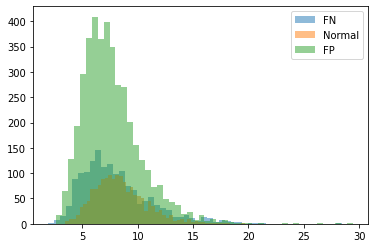

In [43]:
plt.hist(fn_query2gallery, label='FN', bins=50, alpha=0.5)
plt.hist(query2gallery, label='Normal', bins=50, alpha=0.5)
plt.hist(fp_query2gallery, label='FP', bins=50, alpha=0.5)
plt.legend()
plt.show()

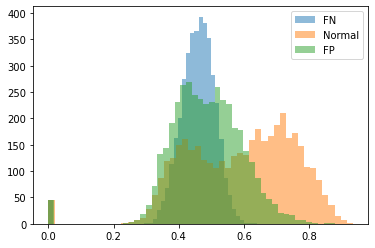

In [39]:
plt.hist(fn_query2gallery, label='FN', bins=50, alpha=0.5)
plt.hist(query2gallery, label='Normal', bins=50, alpha=0.5)
plt.hist(fp_query2gallery, label='FP', bins=50, alpha=0.5)
plt.legend()
plt.show()

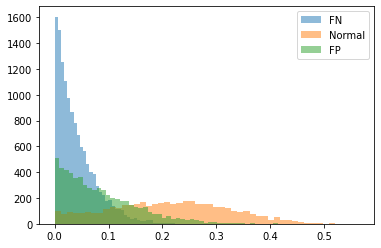

In [40]:
plt.hist(fn_margin_query2gallery, label='FN', bins=50, alpha=0.5)
plt.hist(margin_query2gallery, label='Normal', bins=50, alpha=0.5)
plt.hist(fp_margin_query2gallery, label='FP', bins=50, alpha=0.5)
plt.legend()
plt.show()

- Can we detect through reconstruction error ?

In [41]:
from models.vae_ingredient import model_ingredient, get_model
in_channels = 3
latent_dim = 512
arch = 'AE'

encoder_model = get_model(arch, in_channels, latent_dim)

In [44]:
encoder_model.load_state_dict(torch.load('checkpoints/AE_sop_vae.pt'))
encoder_model.to(device)

AE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (4): Sequential

In [47]:
all_reconstructed_error = torch.tensor([])
with torch.no_grad():
    for batch, labels, _ in tqdm(query_loader, desc='Extracting query features', leave=False, ncols=80):
        batch, labels = map(to_device, (batch, labels))
        z, _, reconstructed = encoder_model(batch)
        reconstructed_error = F.binary_cross_entropy(reconstructed, batch, reduction='none').mean(1).mean(1).mean(1)
        
        print(reconstructed_error.shape)
        all_reconstructed_error = torch.cat((all_reconstructed_error, reconstructed_error.detach().cpu()), dim=0)


Extracting query features:   3%|▌                | 3/93 [00:01<00:44,  2.03it/s]

torch.Size([256])
torch.Size([256])
torch.Size([256])


Extracting query features:   6%|█                | 6/93 [00:02<00:20,  4.27it/s]

torch.Size([256])
torch.Size([256])
torch.Size([256])


Extracting query features:   9%|█▍               | 8/93 [00:02<00:13,  6.12it/s]

torch.Size([256])
torch.Size([256])


Extracting query features:  11%|█▋              | 10/93 [00:02<00:12,  6.53it/s]

torch.Size([256])
torch.Size([256])
torch.Size([256])


Extracting query features:  15%|██▍             | 14/93 [00:03<00:10,  7.48it/s]

torch.Size([256])
torch.Size([256])
torch.Size([256])


Extracting query features:  17%|██▊             | 16/93 [00:03<00:08,  8.72it/s]

torch.Size([256])
torch.Size([256])
torch.Size([256])


Extracting query features:  19%|███             | 18/93 [00:12<01:52,  1.50s/it]

torch.Size([256])


Extracting query features:  22%|███▍            | 20/93 [00:12<01:17,  1.06s/it]

torch.Size([256])
torch.Size([256])


Extracting query features:  25%|███▉            | 23/93 [00:13<00:38,  1.84it/s]

torch.Size([256])
torch.Size([256])
torch.Size([256])


Extracting query features:  26%|████▏           | 24/93 [00:13<00:31,  2.21it/s]

torch.Size([256])


Extracting query features:  27%|████▎           | 25/93 [00:15<01:09,  1.03s/it]

torch.Size([256])


Extracting query features:  28%|████▍           | 26/93 [00:22<02:34,  2.31s/it]

torch.Size([256])


Extracting query features:  31%|████▉           | 29/93 [00:22<01:05,  1.03s/it]

torch.Size([256])
torch.Size([256])
torch.Size([256])


Extracting query features:  34%|█████▌          | 32/93 [00:22<00:31,  1.92it/s]

torch.Size([256])
torch.Size([256])
torch.Size([256])


Extracting query features:  35%|█████▋          | 33/93 [00:23<00:34,  1.73it/s]

torch.Size([256])


Extracting query features:  38%|██████          | 35/93 [00:27<00:58,  1.01s/it]

torch.Size([256])
torch.Size([256])


Extracting query features:  40%|██████▎         | 37/93 [00:27<00:34,  1.63it/s]

torch.Size([256])
torch.Size([256])
torch.Size([256])


Extracting query features:  43%|██████▉         | 40/93 [00:27<00:18,  2.86it/s]

torch.Size([256])
torch.Size([256])


Extracting query features:  44%|███████         | 41/93 [00:28<00:20,  2.52it/s]

torch.Size([256])


Extracting query features:  45%|███████▏        | 42/93 [00:31<01:01,  1.20s/it]

torch.Size([256])


Extracting query features:  47%|███████▌        | 44/93 [00:32<00:35,  1.39it/s]

torch.Size([256])
torch.Size([256])


Extracting query features:  49%|███████▉        | 46/93 [00:32<00:20,  2.26it/s]

torch.Size([256])
torch.Size([256])
torch.Size([256])


Extracting query features:  52%|████████▎       | 48/93 [00:32<00:13,  3.38it/s]

torch.Size([256])
torch.Size([256])


Extracting query features:  55%|████████▊       | 51/93 [00:38<00:44,  1.05s/it]

torch.Size([256])
torch.Size([256])


Extracting query features:  57%|█████████       | 53/93 [00:39<00:26,  1.50it/s]

torch.Size([256])
torch.Size([256])


Extracting query features:  59%|█████████▍      | 55/93 [00:39<00:16,  2.33it/s]

torch.Size([256])
torch.Size([256])


Extracting query features:  60%|█████████▋      | 56/93 [00:39<00:16,  2.31it/s]

torch.Size([256])


Extracting query features:  61%|█████████▊      | 57/93 [00:40<00:22,  1.57it/s]

torch.Size([256])


Extracting query features:  62%|█████████▉      | 58/93 [00:43<00:37,  1.06s/it]

torch.Size([256])


Extracting query features:  66%|██████████▍     | 61/93 [00:43<00:16,  1.90it/s]

torch.Size([256])
torch.Size([256])
torch.Size([256])


Extracting query features:  68%|██████████▊     | 63/93 [00:43<00:10,  2.80it/s]

torch.Size([256])
torch.Size([256])
torch.Size([256])


Extracting query features:  70%|███████████▏    | 65/93 [00:44<00:10,  2.56it/s]

torch.Size([256])


Extracting query features:  73%|███████████▋    | 68/93 [00:47<00:14,  1.78it/s]

torch.Size([256])
torch.Size([256])
torch.Size([256])


Extracting query features:  75%|████████████    | 70/93 [00:47<00:09,  2.53it/s]

torch.Size([256])
torch.Size([256])
torch.Size([256])


Extracting query features:  77%|████████████▍   | 72/93 [00:47<00:06,  3.44it/s]

torch.Size([256])


Extracting query features:  78%|████████████▌   | 73/93 [00:48<00:07,  2.69it/s]

torch.Size([256])


Extracting query features:  81%|████████████▉   | 75/93 [00:53<00:19,  1.09s/it]

torch.Size([256])
torch.Size([256])
torch.Size([256])


Extracting query features:  85%|█████████████▌  | 79/93 [00:54<00:06,  2.16it/s]

torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])


Extracting query features:  87%|█████████████▉  | 81/93 [00:54<00:05,  2.21it/s]

torch.Size([256])


Extracting query features:  90%|██████████████▍ | 84/93 [00:59<00:07,  1.21it/s]

torch.Size([256])
torch.Size([256])
torch.Size([256])


Extracting query features:  92%|██████████████▊ | 86/93 [00:59<00:04,  1.74it/s]

torch.Size([256])
torch.Size([256])
torch.Size([256])


Extracting query features:  95%|███████████████▏| 88/93 [00:59<00:02,  2.41it/s]

torch.Size([256])


Extracting query features:  96%|███████████████▎| 89/93 [01:00<00:01,  2.13it/s]

torch.Size([256])


Extracting query features:  99%|███████████████▊| 92/93 [01:03<00:00,  1.80it/s]

torch.Size([256])
torch.Size([256])
torch.Size([256])


torch.Size([147])


In [48]:
fn_reconstructed_error = np.asarray(all_reconstructed_error)[np.where(fns == True)[0]]
fp_reconstructed_error = np.asarray(all_reconstructed_error)[np.where(fps == True)[0]]
normal_reconstructed_error = np.asarray(all_reconstructed_error)[np.where((fps == False) & (fns == False))[0]]

In [49]:
train_reconstructed_error = torch.tensor([])
with torch.no_grad():
    for batch, labels, _ in tqdm(loaders.train_noshuffle, desc='Extracting query features', leave=False, ncols=80):
        batch, labels = map(to_device, (batch, labels))
        z, _, reconstructed = encoder_model(batch)
        reconstructed_error = F.binary_cross_entropy(reconstructed, batch, reduction='none').mean(1).mean(1).mean(1)
        print(reconstructed_error.shape)
        train_reconstructed_error = torch.cat((all_reconstructed_error, reconstructed_error.detach().cpu()), dim=0)


Extracting query features:   3%|▌                | 2/68 [00:09<04:08,  3.76s/it]

torch.Size([256])
torch.Size([256])


Extracting query features:   6%|█                | 4/68 [00:09<01:33,  1.46s/it]

torch.Size([256])
torch.Size([256])
torch.Size([256])


Extracting query features:   9%|█▌               | 6/68 [00:09<00:49,  1.25it/s]

torch.Size([256])
torch.Size([256])


Extracting query features:  12%|██               | 8/68 [00:09<00:31,  1.92it/s]

torch.Size([256])


Extracting query features:  16%|██▌             | 11/68 [00:14<00:56,  1.01it/s]

torch.Size([256])
torch.Size([256])
torch.Size([256])


Extracting query features:  19%|███             | 13/68 [00:15<00:34,  1.57it/s]

torch.Size([256])
torch.Size([256])


Extracting query features:  21%|███▎            | 14/68 [00:15<00:27,  1.98it/s]

torch.Size([256])
torch.Size([256])


Extracting query features:  24%|███▊            | 16/68 [00:15<00:17,  2.98it/s]

torch.Size([256])


Extracting query features:  26%|████▏           | 18/68 [00:18<00:40,  1.24it/s]

torch.Size([256])
torch.Size([256])
torch.Size([256])


Extracting query features:  31%|████▉           | 21/68 [00:19<00:19,  2.40it/s]

torch.Size([256])
torch.Size([256])


Extracting query features:  34%|█████▍          | 23/68 [00:19<00:13,  3.37it/s]

torch.Size([256])
torch.Size([256])
torch.Size([256])


Extracting query features:  38%|██████          | 26/68 [00:25<00:47,  1.14s/it]

torch.Size([256])
torch.Size([256])


Extracting query features:  43%|██████▊         | 29/68 [00:25<00:21,  1.81it/s]

torch.Size([256])
torch.Size([256])
torch.Size([256])


Extracting query features:  46%|███████▎        | 31/68 [00:26<00:13,  2.64it/s]

torch.Size([256])
torch.Size([256])


Extracting query features:  47%|███████▌        | 32/68 [00:26<00:11,  3.04it/s]

torch.Size([256])


Extracting query features:  50%|████████        | 34/68 [00:31<00:39,  1.16s/it]

torch.Size([256])
torch.Size([256])


Extracting query features:  54%|████████▋       | 37/68 [00:32<00:16,  1.83it/s]

torch.Size([256])
torch.Size([256])
torch.Size([256])


Extracting query features:  59%|█████████▍      | 40/68 [00:32<00:09,  3.07it/s]

torch.Size([256])
torch.Size([256])
torch.Size([256])


Extracting query features:  60%|█████████▋      | 41/68 [00:35<00:21,  1.24it/s]

torch.Size([256])


Extracting query features:  65%|██████████▎     | 44/68 [00:35<00:10,  2.27it/s]

torch.Size([256])
torch.Size([256])
torch.Size([256])


Extracting query features:  68%|██████████▊     | 46/68 [00:35<00:06,  3.16it/s]

torch.Size([256])
torch.Size([256])


Extracting query features:  71%|███████████▎    | 48/68 [00:35<00:04,  4.20it/s]

torch.Size([256])
torch.Size([256])


Extracting query features:  72%|███████████▌    | 49/68 [00:40<00:21,  1.16s/it]

torch.Size([256])


Extracting query features:  74%|███████████▊    | 50/68 [00:42<00:20,  1.16s/it]

torch.Size([256])
torch.Size([256])
torch.Size([256])


Extracting query features:  76%|████████████▏   | 52/68 [00:42<00:12,  1.33it/s]

torch.Size([256])


Extracting query features:  82%|█████████████▏  | 56/68 [00:42<00:04,  2.45it/s]

torch.Size([256])
torch.Size([256])
torch.Size([256])


Extracting query features:  84%|█████████████▍  | 57/68 [00:47<00:12,  1.17s/it]

torch.Size([256])


Extracting query features:  87%|█████████████▉  | 59/68 [00:55<00:18,  2.04s/it]

torch.Size([256])
torch.Size([256])


Extracting query features:  91%|██████████████▌ | 62/68 [00:55<00:05,  1.07it/s]

torch.Size([256])
torch.Size([256])
torch.Size([256])


Extracting query features:  94%|███████████████ | 64/68 [00:55<00:02,  1.64it/s]

torch.Size([256])
torch.Size([256])
torch.Size([256])


Extracting query features: 100%|████████████████| 68/68 [01:03<00:00,  1.15s/it]

torch.Size([256])
torch.Size([256])
torch.Size([188])


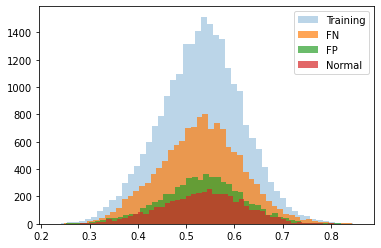

In [50]:
plt.hist(train_reconstructed_error.numpy(), bins=50, label='Training', alpha=0.3)
plt.hist(fn_reconstructed_error, bins=50, label='FN', alpha=0.7)
plt.hist(fp_reconstructed_error, bins=50, label='FP', alpha=0.7)
plt.hist(normal_reconstructed_error, bins=50, label='Normal', alpha=0.7)

plt.legend()
plt.show()